In [365]:
import numpy as np

In [366]:
%matplotlib notebook
from matplotlib import pyplot as plt

In [367]:
FOV = np.array([5, 5])
mxSize = np.array([128, 128], dtype=int)
deltaK = np.divide(1.0, FOV)

In [368]:
rngs = []
for fovElem, mxElem in zip(FOV, mxSize):
    deltaK = 1 / fovElem
    pixSize = fovElem / mxElem
    zeroPt = (deltaK) * np.floor(mxElem / 2)
    rngs.append(np.arange(-zeroPt, 1/pixSize - zeroPt, deltaK))

In [369]:
X, Y = np.meshgrid(rngs[0], rngs[1])
traj = np.array([X.ravel(), Y.ravel()])
print(traj.shape)

(2, 16384)


<IPython.core.display.Javascript object>


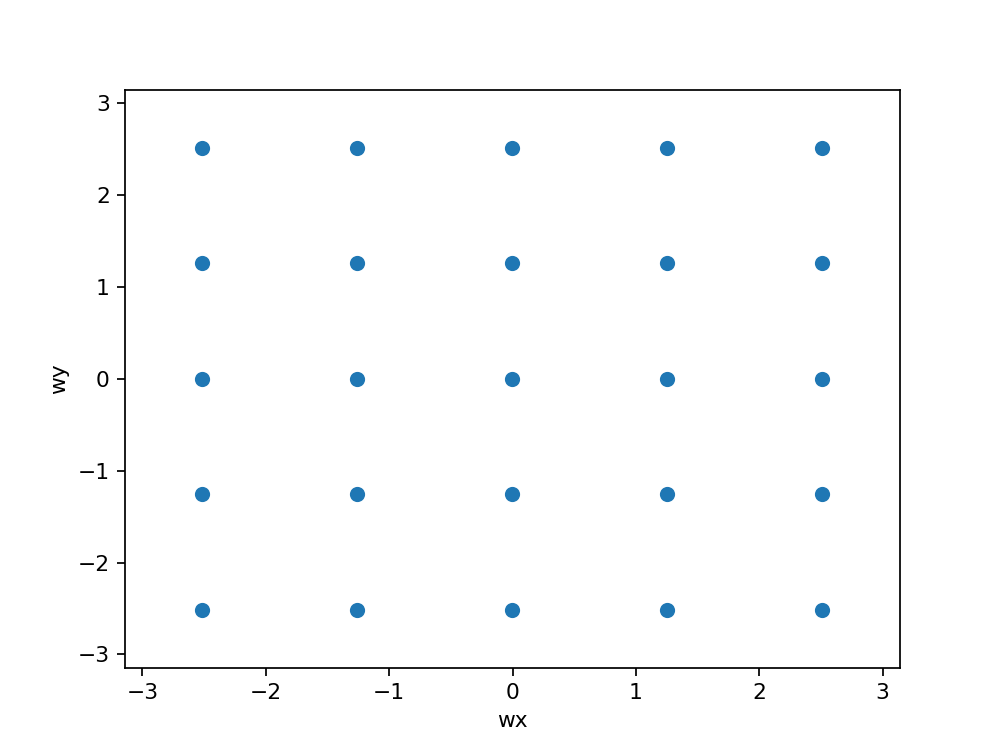

(-3.141592653589793, 3.141592653589793)

In [370]:
fig, ax = plt.subplots()
ax.scatter(2*np.pi*traj[0], 2*np.pi*traj[1])
ax.set_xlabel('wx')
ax.set_ylabel('wy')
ax.set_xlim([-np.pi, np.pi])
ax.set_ylim([-np.pi, np.pi])

In [371]:
# Create a simple polygon
polygon = []
polygon.append(np.array([-1.0, -1.0]))
polygon.append(np.array([1.0, -1.0]))
polygon.append(np.array([1.0, 1.0]))
polygon.append(np.array([0.0, 0.5]))
polygon.append(np.array([-1, 1]))

<IPython.core.display.Javascript object>


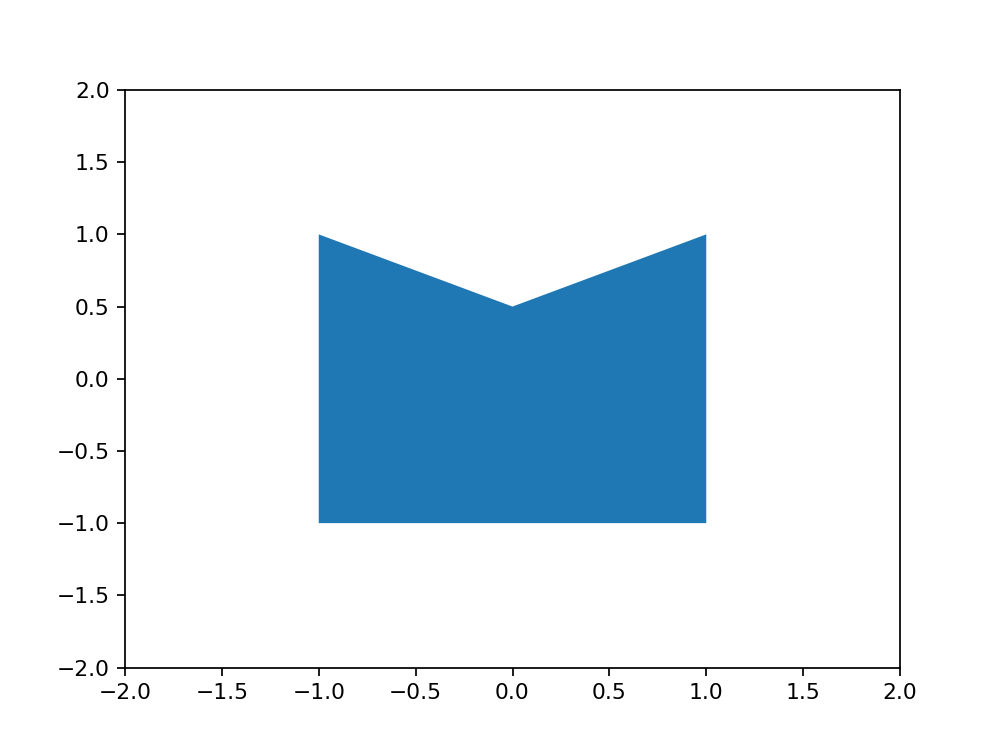

(-2, 2)

In [372]:
from matplotlib.patches import Polygon
poly = Polygon(polygon)
fig, ax = plt.subplots()
ax.add_patch(poly)
ax.set_xlim([-2, 2])
ax.set_ylim([-2, 2])

In [373]:
from scipy.special import spherical_jn

polygon_shifted = np.roll(polygon, -1, axis=0)
cn = 0.5 * (polygon + polygon_shifted)
pdiff = (polygon_shifted - polygon)

def cross2d(v1, v2):
    return np.array([v1[1]-v2[1], -(v1[0] - v2[0])])

coeffs = np.zeros((traj.shape[1], 1), dtype=complex)

for colIdx in range(traj.shape[1]):
    k = traj[:, colIdx]
    
    #special case for k = 0
    knorm = np.linalg.norm(k)

    if knorm <= 1000 * np.finfo(float).eps:
        print("found k = 0")
        sum_term = 0
        for vertIdx in range(len(polygon)):
            u = polygon_shifted[vertIdx]
            v = polygon[vertIdx]
            sum_term += np.abs(u[0]*v[1] - u[1]*v[0])
        
        coeffs[colIdx] = 0.5 * sum_term
        
        continue
    
    multiplier = 1j / (2.0 * np.pi * np.power(knorm, 2))
    sum_term = 0
    for vertIdx in range(len(polygon)):
        exp_term = np.exp(-2.0 * np.pi * 1j * k.dot(cn[vertIdx]))
        ln = cross2d(polygon_shifted[vertIdx], polygon[vertIdx])
        bessel_arg = np.pi * k.dot(pdiff[vertIdx])
        sum_term += k.dot(ln) * spherical_jn(0, bessel_arg) * exp_term;
    
    coeffs[colIdx] = multiplier * sum_term

found k = 0


<IPython.core.display.Javascript object>


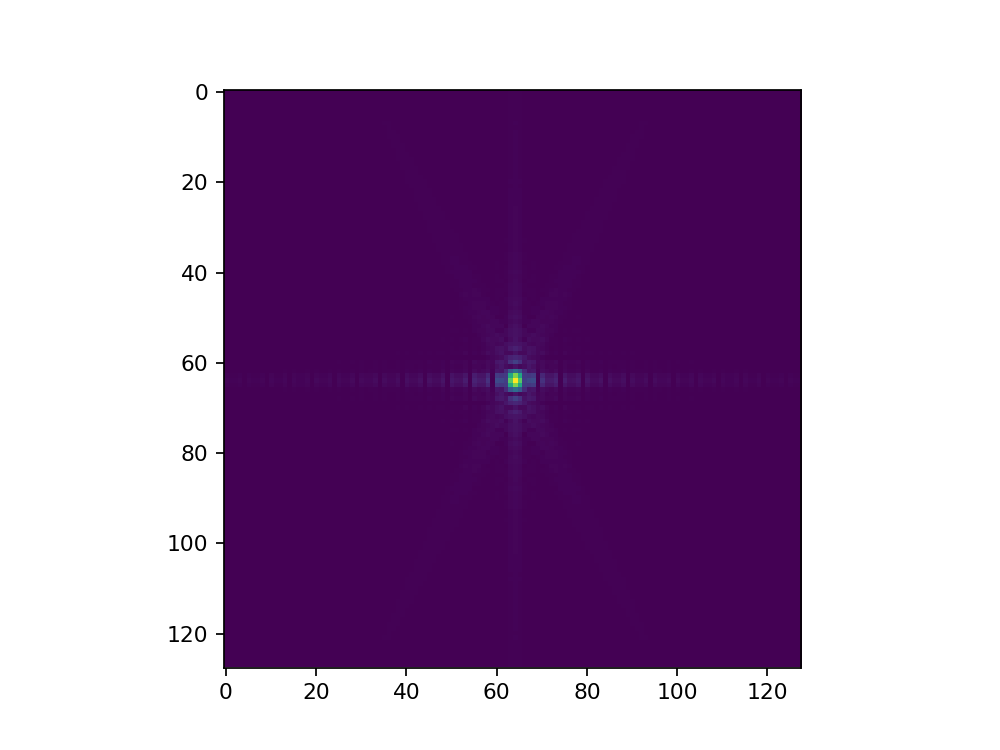

In [374]:
npcoeffs = np.array([(1/np.prod(FOV))*coeffs])
npcoeffs = npcoeffs.reshape(mxSize)
fig, ax = plt.subplots()
ax.imshow(np.abs(npcoeffs))

<IPython.core.display.Javascript object>


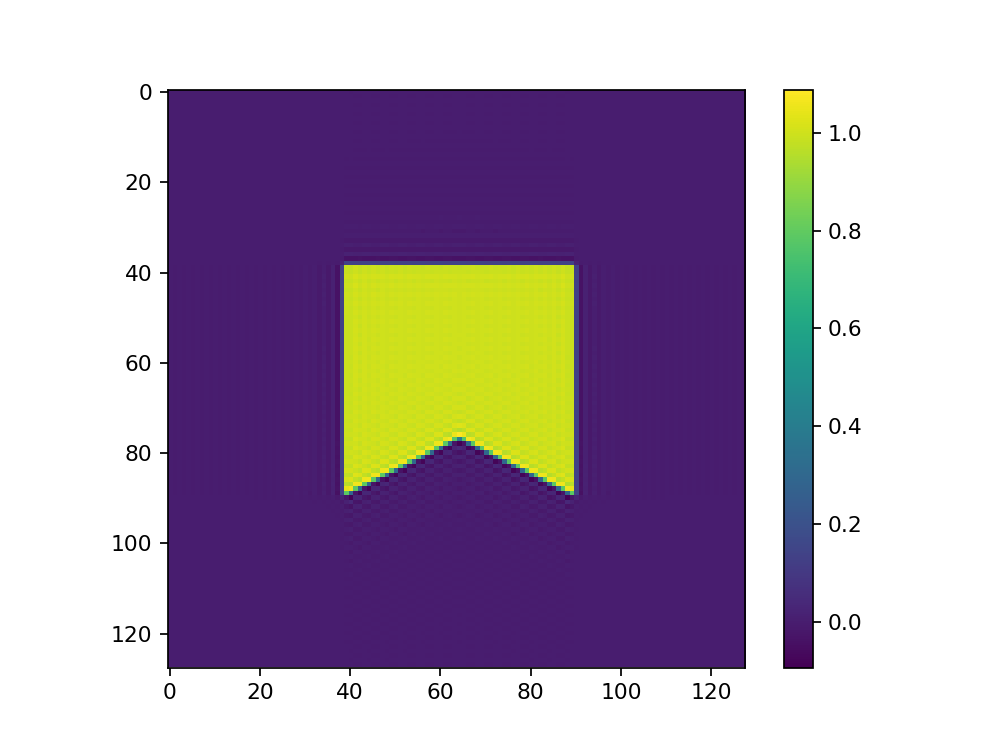

In [375]:
recon = np.fft.ifftn(np.fft.ifftshift(npcoeffs))
fig, ax = plt.subplots()
im = ax.imshow(np.real(np.fft.fftshift(len(coeffs) * recon)))
cbar = ax.figure.colorbar(im, ax=ax)

In [376]:
feps = np.finfo(float).eps
print(feps)

2.22044604925e-16
